Here we have 7 different classes of skin cancer.

Melanocytic nevi (nv)

Melanoma (mel)

Benign keratosis-like lesions (bkl)

Basal cell carcinoma

Actinic keratoses

Vascular lesions

Dermatofibroma (df)

**Importing dependencies**

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os
import seaborn as sns
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

KeyboardInterrupt: 

**Loading the Data**

In [ ]:
df = pd.read_csv(r'C:\Users\User\Documents\kaggle\skin_data\HAM10000_metadata.csv')

In [3]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [5]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [6]:
df.shape

(10015, 7)

**Data Preprocessing**

Creating dictionary for displaying more human-friendly labels.

In [7]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Bening keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = 'C:/Users/User/Documents/kaggle/skin_data'

**Merge images from both folders into one dictionary**

In [8]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [9]:
print(imageid_path_dict)

{'ISIC_0024306': 'C:/Users/User/Documents/kaggle/skin_data\\HAM10000_images_part_1\\ISIC_0024306.jpg', 'ISIC_0024307': 'C:/Users/User/Documents/kaggle/skin_data\\HAM10000_images_part_1\\ISIC_0024307.jpg', 'ISIC_0024308': 'C:/Users/User/Documents/kaggle/skin_data\\HAM10000_images_part_1\\ISIC_0024308.jpg', 'ISIC_0024309': 'C:/Users/User/Documents/kaggle/skin_data\\HAM10000_images_part_1\\ISIC_0024309.jpg', 'ISIC_0024310': 'C:/Users/User/Documents/kaggle/skin_data\\HAM10000_images_part_1\\ISIC_0024310.jpg', 'ISIC_0024311': 'C:/Users/User/Documents/kaggle/skin_data\\HAM10000_images_part_1\\ISIC_0024311.jpg', 'ISIC_0024312': 'C:/Users/User/Documents/kaggle/skin_data\\HAM10000_images_part_1\\ISIC_0024312.jpg', 'ISIC_0024313': 'C:/Users/User/Documents/kaggle/skin_data\\HAM10000_images_part_1\\ISIC_0024313.jpg', 'ISIC_0024314': 'C:/Users/User/Documents/kaggle/skin_data\\HAM10000_images_part_1\\ISIC_0024314.jpg', 'ISIC_0024315': 'C:/Users/User/Documents/kaggle/skin_data\\HAM10000_images_part_1

**Creating new columns for better understanding of features**

In [10]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes


In [11]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:/Users/User/Documents/kaggle/skin_data\HAM10...,Bening keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:/Users/User/Documents/kaggle/skin_data\HAM10...,Bening keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:/Users/User/Documents/kaggle/skin_data\HAM10...,Bening keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:/Users/User/Documents/kaggle/skin_data\HAM10...,Bening keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:/Users/User/Documents/kaggle/skin_data\HAM10...,Bening keratosis-like lesions,2


**Data Cleaning**

In [12]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [13]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [14]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

**Exploratory Data Analysis**

Gender wise differentiability

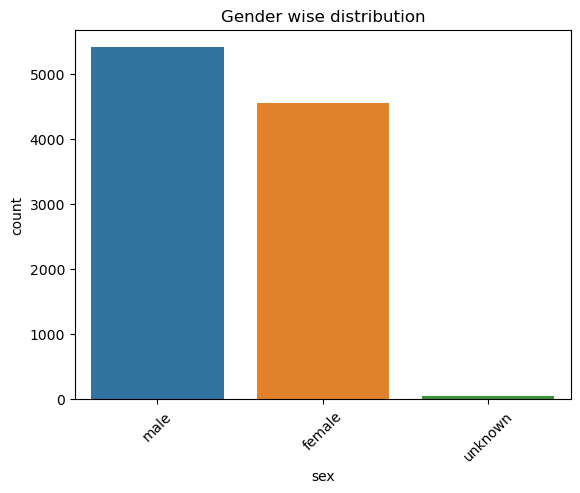

In [15]:
ax = sns.countplot(x = 'sex', data = df)
plt.title('Gender wise distribution')
plt.xticks(rotation=45)
plt.show()

In [16]:
df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

We can see that males are more affected. 

Cell type affect on patients

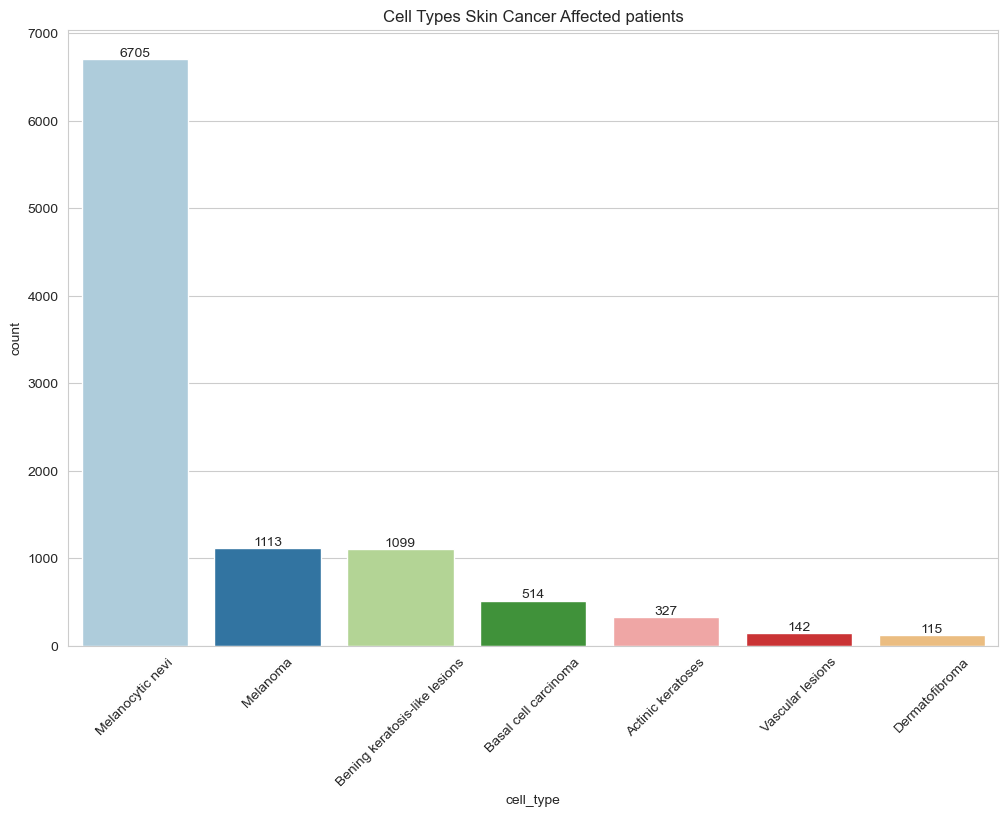

In [17]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.show()

1. The number of cases of Melanocytic nevi is way more that others
2. Melonoma which is more critical is less wide spread.

Gender vs Cell Type

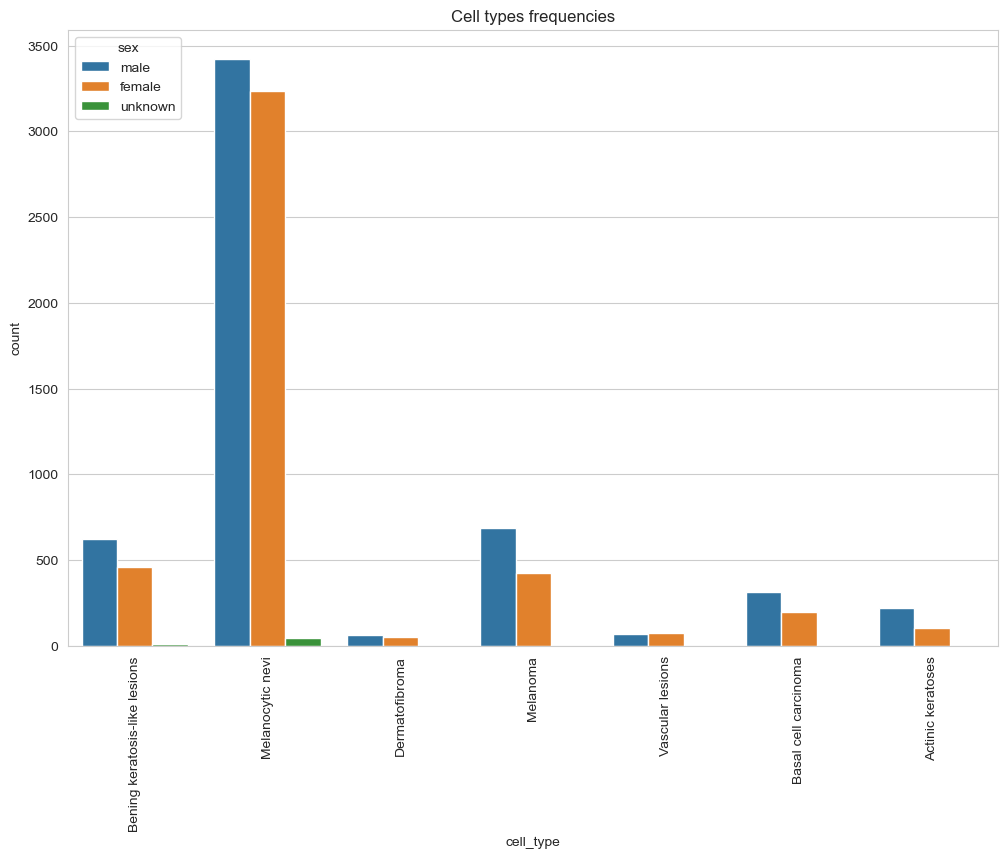

In [18]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type', hue='sex', data = df)
plt.title('Cell types frequencies')
plt.xticks(rotation=90)
plt.show()

We can see that for any type of cancer, majority of the victims are males.

Cell Type

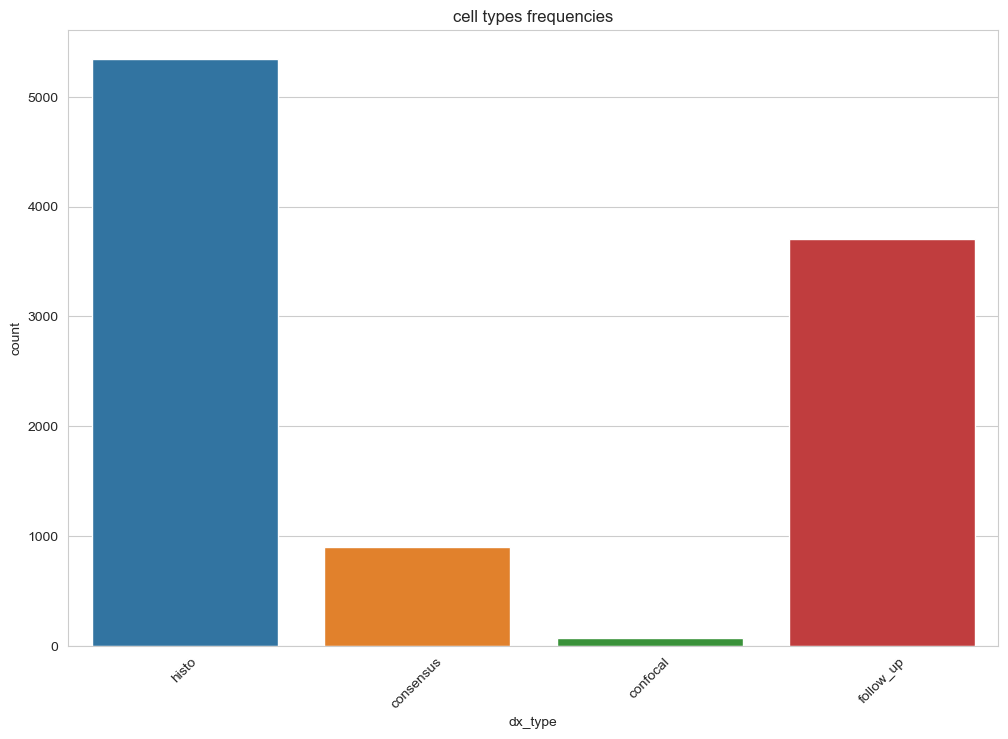

In [19]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type', data=df)
plt.title('cell types frequencies')
plt.xticks(rotation=45)
plt.show()

Gender wise cell type distribution

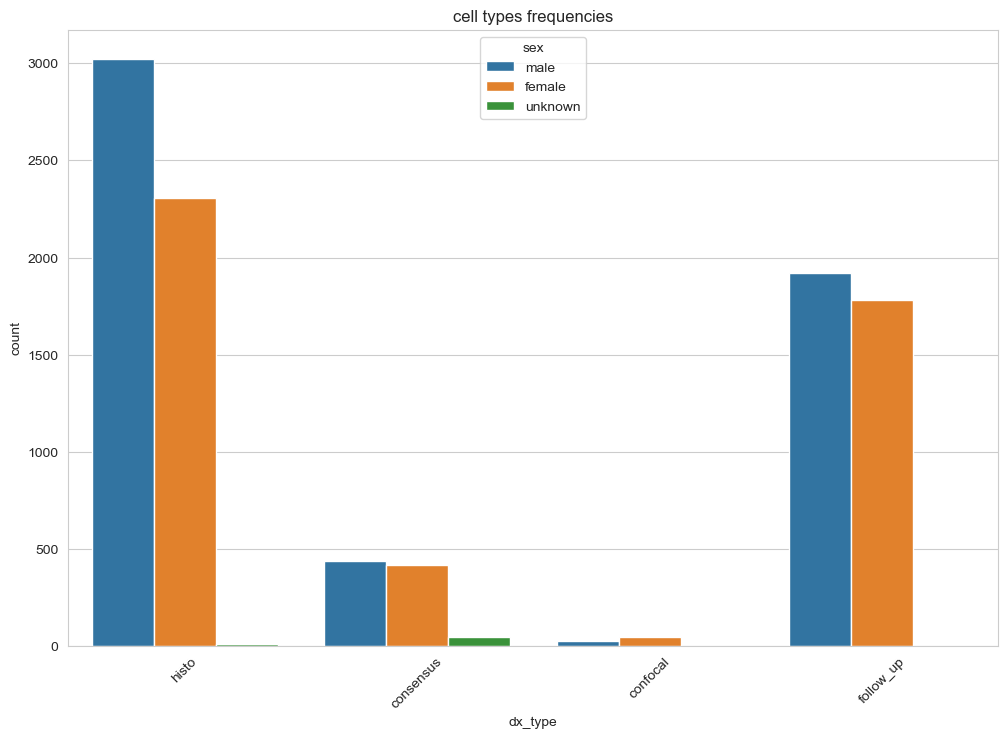

In [20]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type', hue = 'sex', data = df)
plt.title('cell types frequencies')
plt.xticks(rotation=45)
plt.show()

Localization area

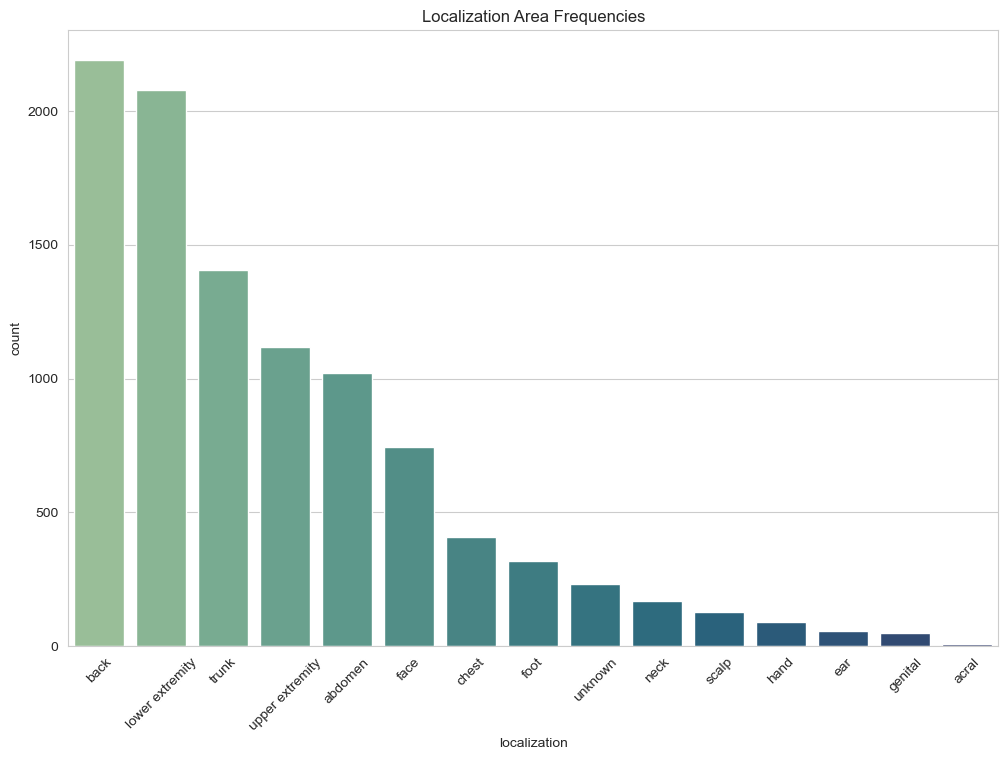

In [21]:
sns.set_style('whitegrid')
fig,axis = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization', data=df, order=df['localization'].value_counts().index, palette='crest')
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

We can see that the most affected areas are back and lower extremity. 

Genderwise localization areas


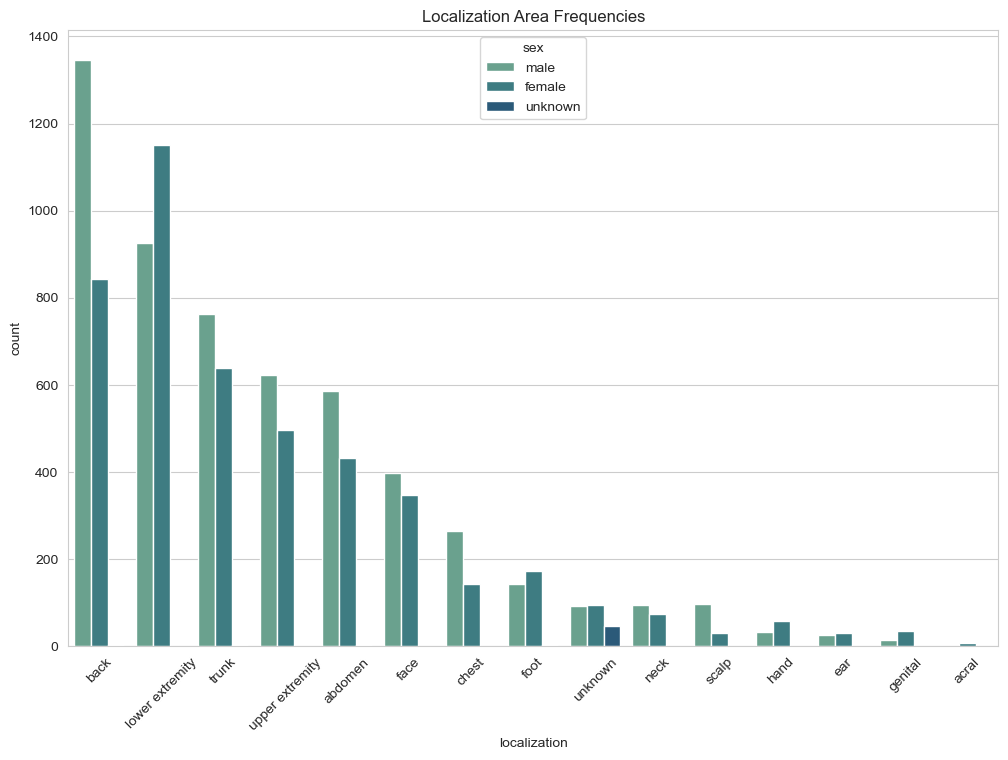

In [22]:
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x = 'localization', hue = 'sex', data = df, order = df['localization'].value_counts().index, palette='crest')
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

Age

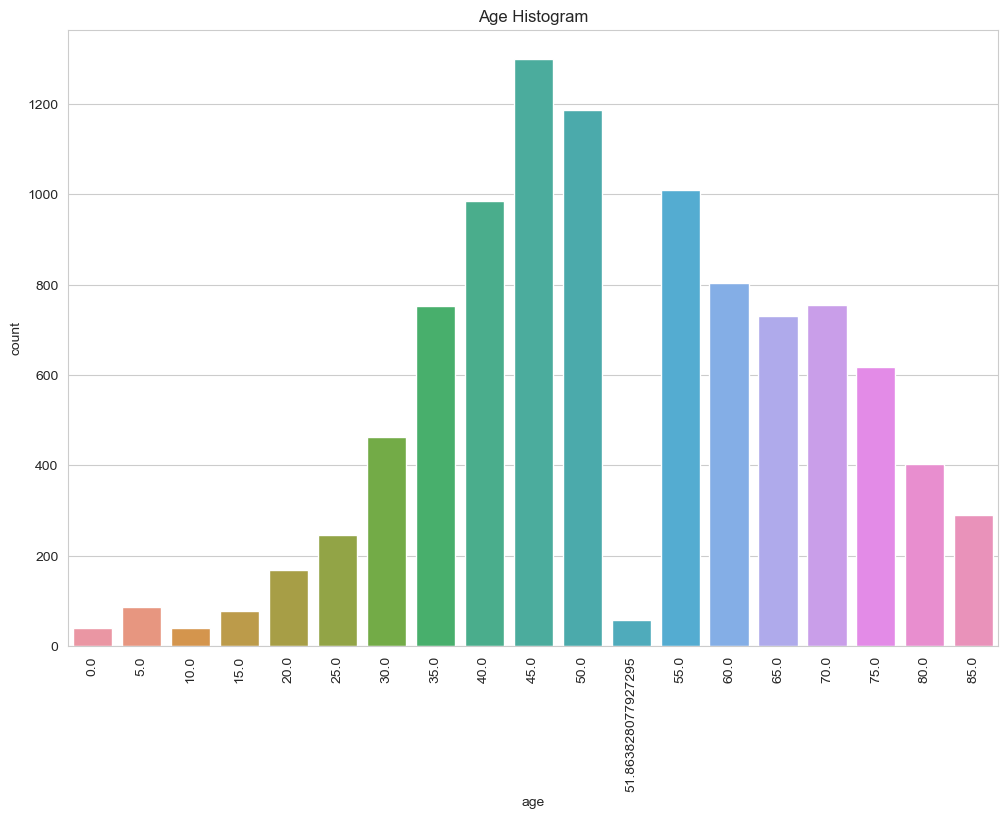

In [23]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x = 'age', data = df)
plt.title('Age Histogram')
plt.xticks(rotation=90)
plt.show()

Gender wise age distribution

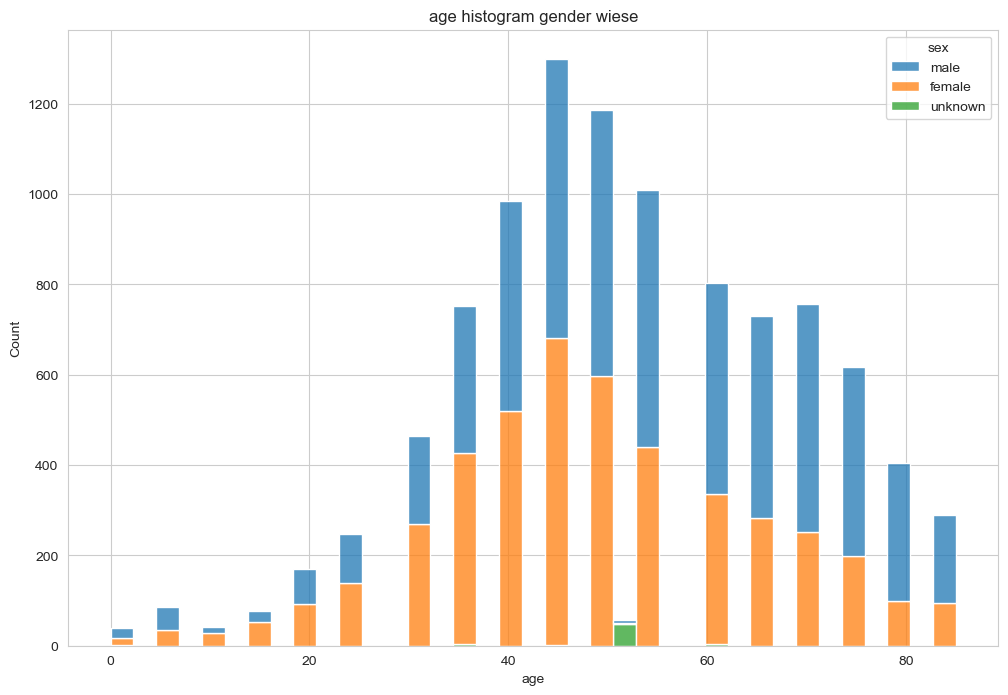

In [24]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x = 'age', hue = 'sex', multiple='stack')
plt.title('age histogram gender wiese')
plt.show()


Cell Type vs Age

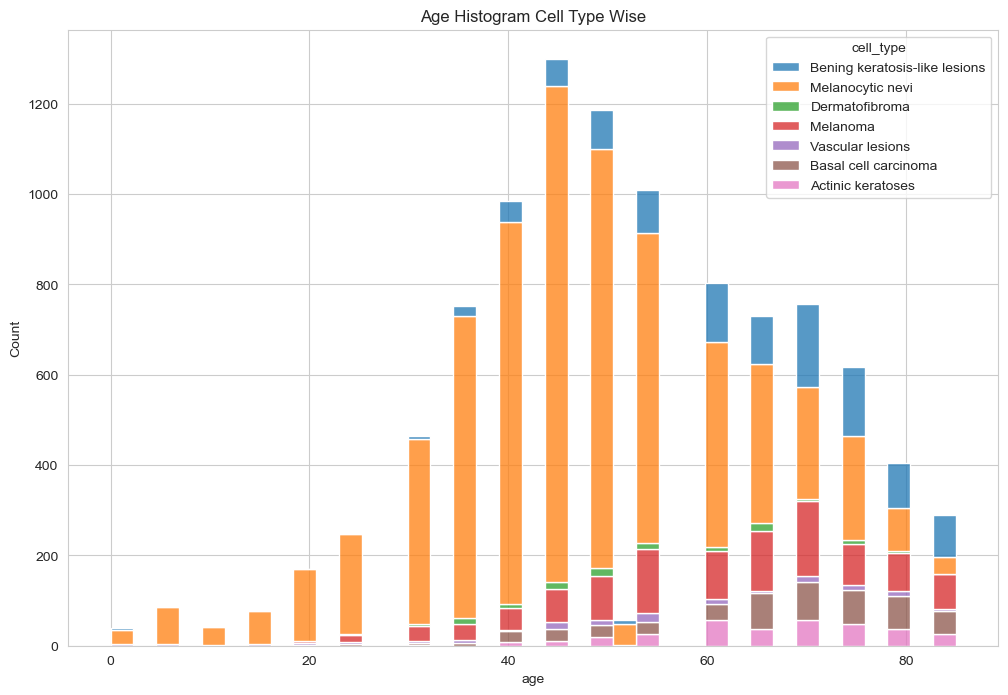

In [25]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='cell_type',multiple='stack')
plt.title('Age Histogram Cell Type Wise')
plt.show()

Localization area vs age

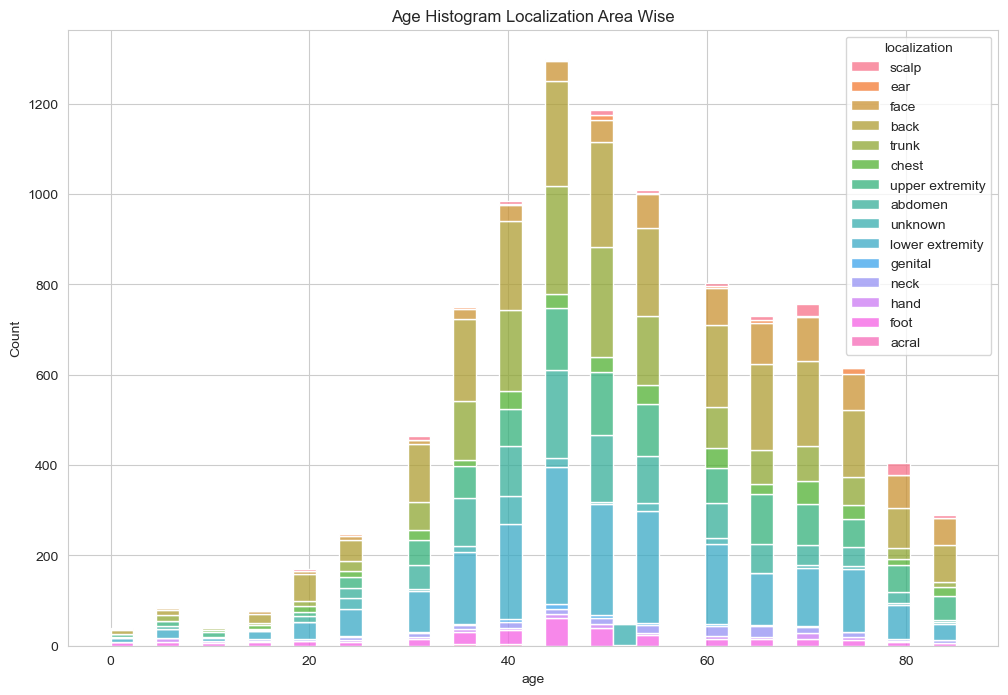

In [26]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='localization',multiple='stack')
plt.title('Age Histogram Localization Area Wise')
plt.show()

**Machine laarning part**

In [27]:
import cv2

In [28]:
# Function to read and resize images
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

In [29]:
image_size = (64, 64)

In [30]:
# Apply the function to each image path in the 'path' column of the dataframe
df['image'] = df['path'].apply(lambda x: read_and_resize_image(x, image_size))

Pictorial representaiton of Images

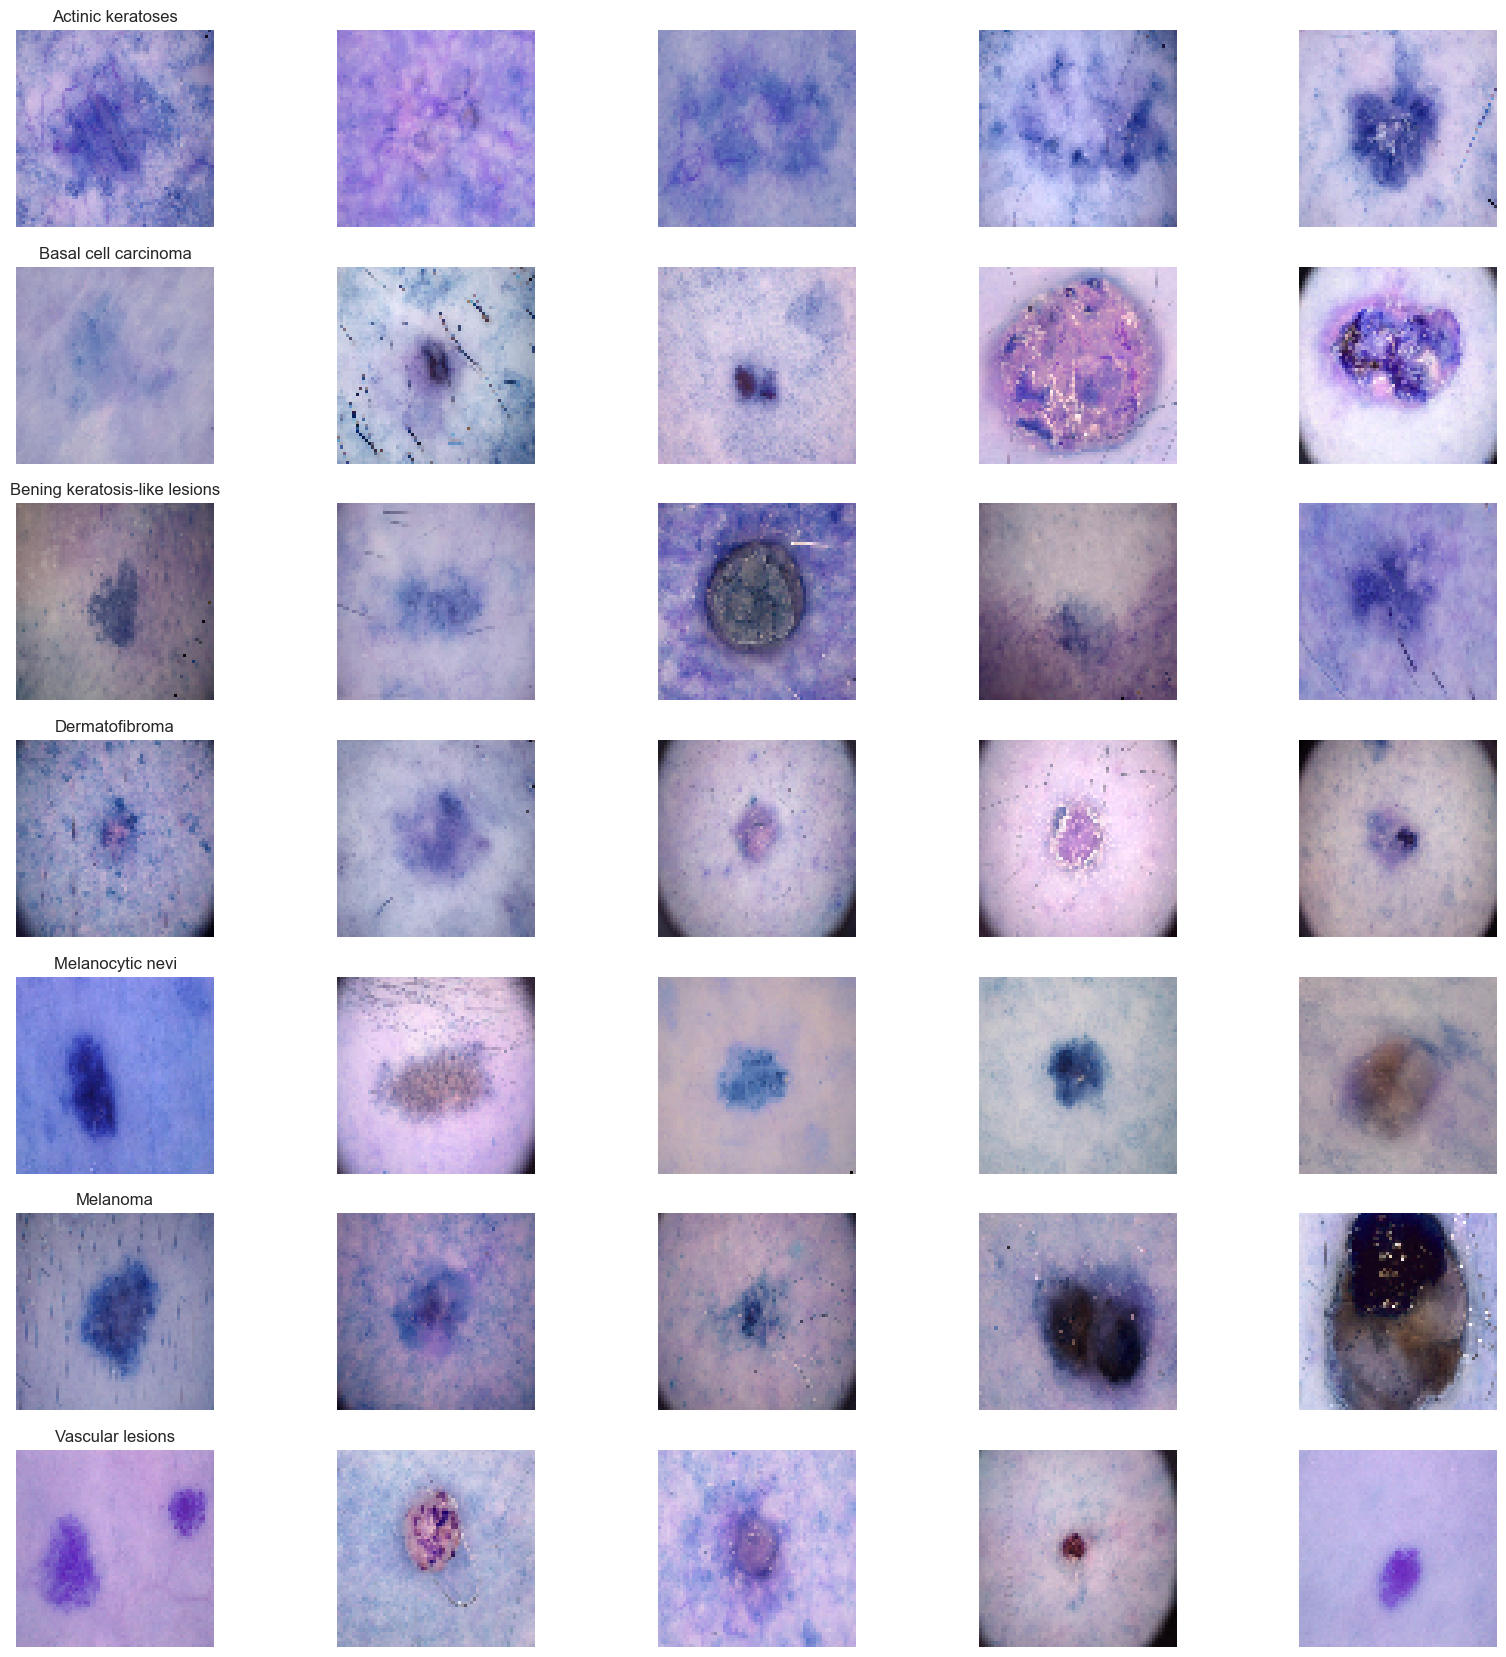

In [31]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)


In [32]:
df['image'].map(lambda x: x.shape).value_counts()

(64, 64, 3)    10015
Name: image, dtype: int64

**Data Modeling**

In [33]:
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cell_type_idx'], random_state=42)

In [34]:
# Extract the image data and target labels for train and test sets
X_train = np.stack(train_df['image'].values)
y_train = train_df['cell_type_idx'].values
X_test = np.stack(test_df['image'].values)
y_test = test_df['cell_type_idx'].values

**Creating the CNN Model**

In [35]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))

Compile the model


In [36]:
model.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

**Train the model**

In [37]:
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.1)

Epoch 1/100
226/226 [==============================] - 16s 68ms/step - loss: 4.8315 - accuracy: 0.6465 - val_loss: 0.8612 - val_accuracy: 0.7095
Epoch 2/100
226/226 [==============================] - 15s 66ms/step - loss: 0.9148 - accuracy: 0.6789 - val_loss: 0.8726 - val_accuracy: 0.7032
Epoch 3/100
226/226 [==============================] - 15s 68ms/step - loss: 0.8647 - accuracy: 0.6961 - val_loss: 0.8430 - val_accuracy: 0.7045
Epoch 4/100
226/226 [==============================] - 18s 80ms/step - loss: 0.8028 - accuracy: 0.7132 - val_loss: 0.8334 - val_accuracy: 0.7170
Epoch 5/100
226/226 [==============================] - 17s 77ms/step - loss: 0.8192 - accuracy: 0.7087 - val_loss: 0.8759 - val_accuracy: 0.7132
Epoch 6/100
226/226 [==============================] - 17s 77ms/step - loss: 0.7655 - accuracy: 0.7176 - val_loss: 0.8334 - val_accuracy: 0.7244
Epoch 7/100
226/226 [==============================] - 17s 74ms/step - loss: 0.7369 - accuracy: 0.7351 - val_loss: 0.8815 - val_ac

In [38]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the accuracy
accuracy = np.mean(y_pred_classes == y_test) * 100
print(f'Test accuracy: {accuracy:.2f}%')

63/63 [==============================] - 1s 18ms/step
Test accuracy: 68.10%


In [39]:
# Create a new DataFrame with 'lesion_id' and 'cell_type_dx' columns from the test data
result_df = pd.DataFrame({'lesion_id': test_df['lesion_id'], 'target': y_test})

# Save the DataFrame to a CSV file
result_df.to_csv('submission.csv', index=False)